### Special cases

Here are some cases where **Methodology 1** is more useful in finding a reasonable ranking than other methodologies.

#### Experiment 4

Consider the following example where all the objects, except one, have IQI distinctly separated from one another, and the IQI of the remaining object overlaps with all the other objects.

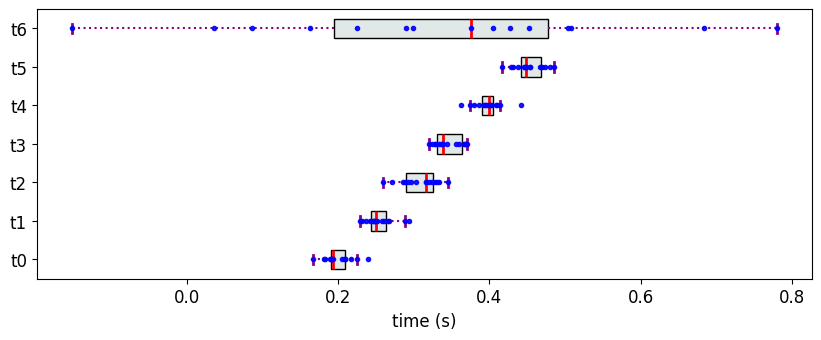

In [11]:
from partial_ranker import MeasurementsSimulator, MeasurementsVisualizer

n1 = [0.2, 0.25, 0.30, 0.35,0.40, 0.45]
M6 = {}

for i in range(len(n1)):
    M6['t{}'.format(i)] = [n1[i], 0.02]

M6['t6']= [0.35,0.27]

ms = MeasurementsSimulator(M6,seed=43)
ms.measure(reps=15)
measurements = ms.get_measurements()

mv = MeasurementsVisualizer(measurements)
fig = mv.show_measurements_boxplots(scale=0.5)

**The Partial Ranks according to Methodology 3**

In this case, **PartialRankerMin** merges all the objects into a single rank, not allowing for discrimination.

In [12]:
from partial_ranker import QuantileComparer, Method,PartialRanker

cm = QuantileComparer(measurements)
cm.compute_quantiles(q_max=75, q_min=25)
cm.compare()

pr = PartialRanker(cm)
pr.compute_ranks(Method.Min)
pr.get_ranks()

{0: {'t0', 't1', 't2', 't3', 't4', 't5', 't6'}}

**The Partial Ranks according to Methodology 2**

In [14]:
pr.compute_ranks(Method.DFGReduced)
pr.get_ranks()

{0: ['t0', 't6', 't1'], 1: ['t2'], 2: ['t3'], 3: ['t4'], 4: ['t5']}

**The Partial Ranks according to Methodology 1**

In [15]:
pr.compute_ranks(Method.DFG)
pr.get_ranks()

{0: ['t0', 't6'], 1: ['t1'], 2: ['t2'], 3: ['t3'], 4: ['t4'], 5: ['t5']}

#### Experiment 5

Consider the following data where objects have overlapping, yet can be arranged in a monotonically increasing fashion. In this case, both **PartialRankerMin** and **PartialRankerDFGReduced** merge all the variants into a single rank.

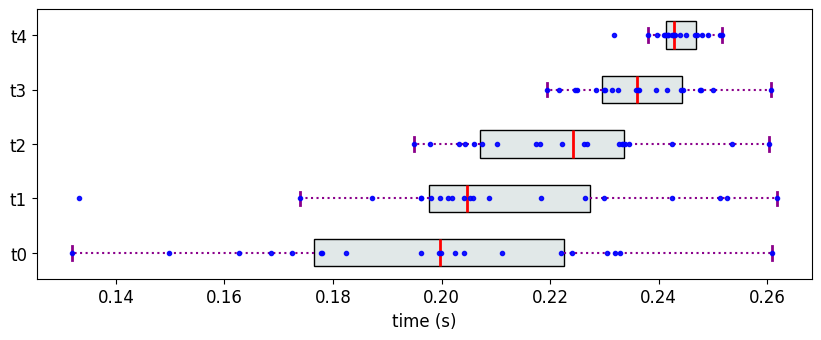

In [19]:
M7 = {}
M7['t0']  = [0.2,0.04] #[mean, std]
M7['t1']  = [0.21,0.03]
M7['t2']  = [0.22,0.02]
M7['t3']  = [0.235,0.01]
M7['t4']  = [0.245,0.005]

ms = MeasurementsSimulator(M7,seed=1459)
ms.measure(reps=20)
measurements = ms.get_measurements()

mv = MeasurementsVisualizer(measurements)
fig = mv.show_measurements_boxplots(scale=0.7)

**The Partial Ranks according to Methodology 3**

In [20]:
from partial_ranker import QuantileComparer, Method,PartialRanker

cm = QuantileComparer(measurements)
cm.compute_quantiles(q_max=75, q_min=25)
cm.compare()

pr = PartialRanker(cm)
pr.compute_ranks(Method.Min)
pr.get_ranks()

{0: {'t0', 't1', 't2', 't3', 't4'}}

**The Partial Ranks according to Methodology 2**

In [21]:
pr.compute_ranks(Method.DFGReduced)
pr.get_ranks()

{0: ['t0', 't1', 't2', 't3', 't4']}

**The Partial Ranks according to Methodology 1**

In [26]:
pr.compute_ranks(Method.DFG)
pr.get_ranks()

{0: ['t0', 't1', 't2'], 1: ['t3', 't4']}

#### Experiment 6

Sometimes, it is useful to compute partial ranks at several quantile intervals, calculate a score for each ranking, and choose the ranking with an optimal score.

Consider the following measurement data:

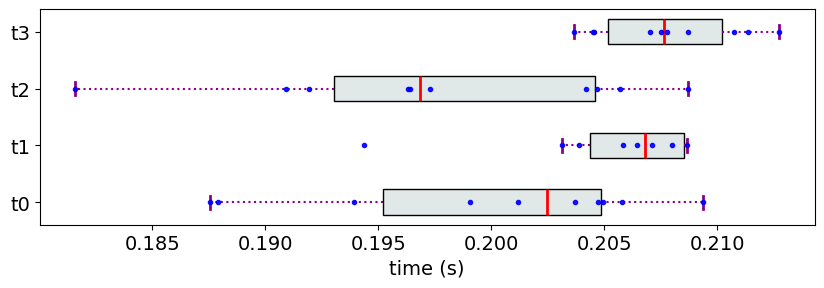

In [39]:
M8 = {}
M8['t0']  = [0.2,0.01] #[mean, std]
M8['t1']  = [0.216,0.01]
M8['t2']  = [0.198,0.01]
M8['t3']  = [0.209,0.003]

ms = MeasurementsSimulator(M8,seed=159)
ms.measure(reps=10)
measurements = ms.get_measurements()

mv = MeasurementsVisualizer(measurements)
fig = mv.show_measurements_boxplots(tick_size=14,scale=0.7)

**The Partial Ranks according to Methodology 1**

At the first glance of the data, it seems like **t2** and **t0** should be in the same rank. However, because of a minor overlap with **t1**, this expected ranking is not possible with neither of the methodologies.

In [83]:
cm = QuantileComparer(measurements)
cm.compute_quantiles(q_max=75, q_min=25)
cm.compare()

pr = PartialRanker(cm)
pr.compute_ranks(Method.DFG)
pr.get_ranks()

{0: ['t0', 't1', 't2'], 1: ['t3']}

**Partial Ranks at Multiple Quantile Intervals**

To address the issue in above example, the partial ranks can be computed at several quantile intervals and the ranks at one of the interval can be chosen by the following technique below (described in Sec. 5 in the paper ).

In [84]:
import numpy as np
import pandas as pd

def reliable_ranking(cm, quantiles):
    pr_ = []
    for (q_max,q_min) in quantiles:
        cm.compute_quantiles(q_max=q_max, q_min=q_min)
        cm.compare()
        pr = PartialRanker(cm)
        pr.compute_ranks(Method.DFG)
        pr_.append(pr)
        
    ranks = {}
    for pr in pr_:
        for obj in pr.ranker.objs:
            ranks[obj] = ranks.get(obj,[]) + [pr.get_rank_obj(obj)]
            
    mean_ranks = {}
    for obj in list(cm.C.keys()):
        mean_ranks[obj] = np.mean(ranks[obj])
        
    avg_rel = [0]*len(quantiles)
    for i in range(len(pr_)):
        for obj in pr_[i].ranker.objs:
            avg_rel[i] = avg_rel[i] + (-abs(pr_[i].get_rank_obj(obj) - mean_ranks[obj]))
        avg_rel[i] = avg_rel[i]/len(pr.ranker.objs)
            
            
    return ranks, mean_ranks, avg_rel


cm = QuantileComparer(measurements)
ranks, mean_ranks, avg_rel = reliable_ranking(cm, [(75,25),(70,30),(65,35),(60,40)])

df = []
cols = []
for k,v in ranks.items():
    df.append([k]+v+[mean_ranks[k]])
df.append(['avg_rel'] + avg_rel + ['-'])
cols = ['obj'] + ['rank@q75-25','rank@q70-30','rank@q65-35','rank@q60-40'] +['mean-rank']

df = pd.DataFrame(df,columns=cols)
df         

,obj,rank@q75-25,rank@q70-30,rank@q65-35,rank@q60-40,mean-rank
0,t0,0.000,0.000,0.000,1.000,0.25
1,t1,0.000,1.000,1.000,2.000,1.0
2,t2,0.000,0.000,0.000,0.000,0.0
3,t3,1.000,1.000,1.000,2.000,1.25
4,avg_rel,-0.375,-0.125,-0.125,-0.625,-


The ranks computed at quantile intervals (70,30) and (65,35) have the highest reliability score.